### Running SGP4 to calculate and plot Fermi beta angle

### <span style="color:red; font-family:Georgia;">Robert Cameron, May 2017</span>

Based on the python implementation of SGP4 orbit propagator
available at https://pypi.python.org/pypi/sgp4/

In [1]:
# specify the date range limits to calculate the beta angle for Fermi
start = "2018-04-01" 
stop = "2018-06-01"

In [2]:
# specify output directory for output text files and plots
outdir = "/Users/rac/Documents/GLAST/ISOC/LATmetrics/beta/"

In [3]:
import numpy as np
import re
import urllib
from math import *
#%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt, mpld3
#plt.figure(figsize = [8, 6])
#plt.rc('font', size = 12)
import sys
from os.path import expanduser
HOME = expanduser("~")
sys.path.append(HOME+'/Documents/GLAST/sgp4-1.4')
from sgp4.earth_gravity import wgs84
from sgp4.io import twoline2rv
from sgp4.ext import jday, invjday, days2mdhms
import datetime as dt     
today = str(dt.date.today())

In [4]:
tle = !tail -2 /Users/rac/Documents/GLAST/FGST-TLE.txt
tle

['2 33053  25.5820 220.4226 0012412 346.7946  13.2264 15.11064994540552',
 'Mon Apr  2 12:43:37 UTC 2018']

In [5]:
webTLE = "http://celestrak.com/NORAD/elements/science.txt"
lines = urllib.request.urlopen(webTLE).readlines()
regex = re.compile(b'(1|2) 33053')
tle = [x.decode().replace('\r\n', '') for x in lines if regex.match(x)]
tle

['1 33053U 08029A   18091.67665072  .00000495  00000-0  11667-4 0  9994',
 '2 33053  25.5819 200.1936 0012634  21.1912 338.9145 15.11066218540989']

In [6]:
satellite = twoline2rv(tle[0], tle[1], wgs84)

In [7]:
(y0,m0,d0) = map(int, start.split("-"))
jd0 = jday(y0,m0,d0,0,0,0)
doy0 = jd0 - jday(y0,1,0,0,0,0)
(y1,m1,d1) = map(int, stop.split("-"))
ndays = int(jday(y1,m1,d1,0,0,0)  - jd0)
(y0, doy0, ndays)

(2018, 91.0, 61)

In [8]:
oformat = "%4d %02d %02d %02d %02d %02d %12.5f %12.6f %12.6f %12.6f %8.3f\n"
fo = open(outdir+"beta_"+today+".txt", "w")
fdoypl = []
betapl = []
for day in range(ndays):
    for hour in range(24):
# add a small amount to the day number to ensure it is always a fraction of a second past the hour
        dinc = day + hour/24.0 + 1.0e-9
        jd = jd0 + dinc
        fdoy = doy0 + dinc
        (y,mon,d,h,m,s) = invjday(jd)    # need jd for the sun ephemeris
        s = int(s)
        fdoypl.append(fdoy)
        pos, vel = satellite.propagate(y,mon,d,h,m,s)  # this is the key line to specify the date
        pole = np.cross(pos,vel)
        polelen = np.linalg.norm(pole)
# calculate sun coordinates
        n = jd - 2451545.0
        L = (280.460 + 0.9856474 * n) % 360
        g = radians((357.528 + 0.9856003 * n) % 360)
        lamda = radians(L + 1.915 * sin(g) + 0.020 * sin(2*g))
        epsilon = radians(23.439 - 0.0000004 * n)
        Xsun = cos(lamda)
        Ysun = cos(epsilon) * sin(lamda)
        Zsun = sin(epsilon) * sin(lamda)
        dotprod = np.dot([Xsun,Ysun,Zsun], pole)
        beta = degrees(np.arcsin(dotprod/polelen))
        betapl.append(beta)
        fo.write(oformat % (y, mon, d, h, m, s, fdoy, pos[0], pos[1], pos[2], beta))
fo.close()

<IPython.core.display.Javascript object>


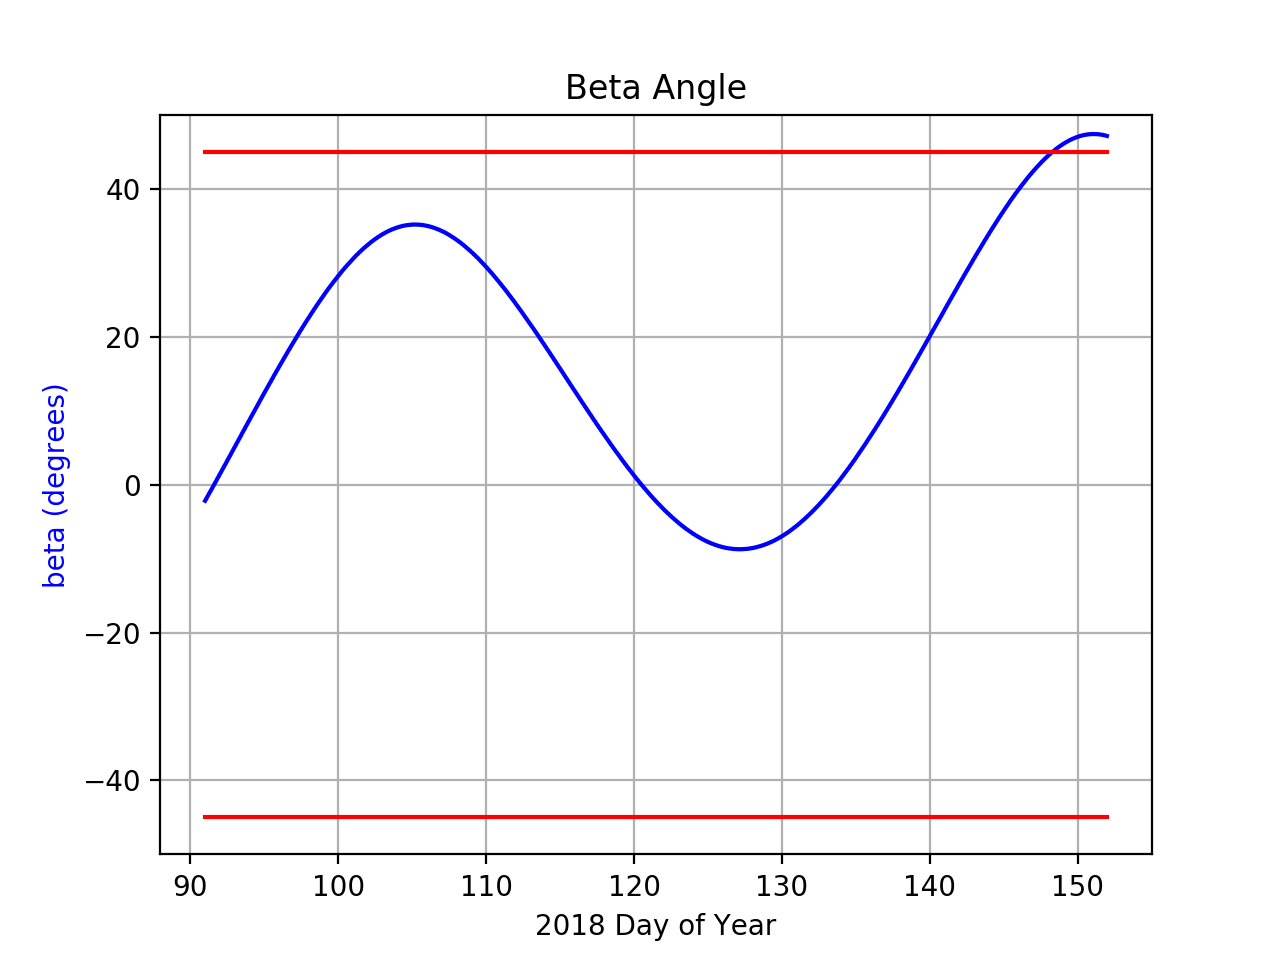

In [9]:
fig, ax = plt.subplots()

ax.set_ylim(-50,50)
ax.grid('on')
ax.plot(fdoypl, betapl, label = 'Beta angle', color = 'b')
#ax.set_minorticks_on()
ax.set_xlabel(str(y0)+' Day of Year')
ax.set_ylabel('beta (degrees)', color = 'b')
ax.set_title('Beta Angle')

xminmax = [fdoypl[0],fdoypl[-1]]

ax.plot(xminmax,[-45,-45], color = 'r')
ax.plot(xminmax,[45,45], color = 'r')

mpld3.enable_notebook()

In [10]:
plt.savefig(outdir+'beta_'+today+'.png')